In [1]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation

from model import Model

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

# device = torch.device("cpu")

GPU available


In [2]:
## Load data
data_path = "/home/loek/projects/rnn/DNN/data/"

classes = pd.read_csv(data_path + "amazing data/Class.txt", sep=" ", header=0)
properties = pd.read_csv(data_path + "amazing data/Properties.txt", sep=" ", header=0)

names = classes.columns.to_numpy()

inputs = properties.to_numpy().T
outputs = np.array([list(classes[index]) for index in classes])

# encoding = Encoding(dict(zip(names, inputs)))
encoding = OneHot(names)

inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)
outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)

inputs, outputs = outputs, inputs

dataset = TensorDataset(inputs, outputs)
train_datasets = [dataset]
val_dataset = [dataset]

tracked_datasets = val_dataset + train_datasets

In [3]:
gain = 0.4
P = 1000
L = 20

In [4]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [5]:
## Setup compiler

# Define hyperparameters
n_epochs = 10000
lr = 0.000003

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "hidden_early": ActivationTracker(model, lambda inputs: model(inputs)[1][1]),
    "hidden_late": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) * (9 / 10))]
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [6]:
## Get all activations before training
activations_0 = []

for layer in range(len(model) - 1):
    act = get_activations(val_dataset, lambda inputs: model(inputs)[1][layer], encoding)
    activations_0.append(act)

index_names = activations_0[0].index.names
activations_0 = pd.concat(activations_0, keys=list(range(len(activations_0))))
activations_0.index = activations_0.index.set_names(["Epoch"] + index_names)

In [7]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
)

Training:   1%|▏         | 38/3000 [00:06<08:37,  5.72steps/s, train_loss=0.32190, val_loss=0.32190]

Training:   1%|▏         | 43/3000 [00:06<08:43,  5.65steps/s, train_loss=0.32169, val_loss=0.32169]

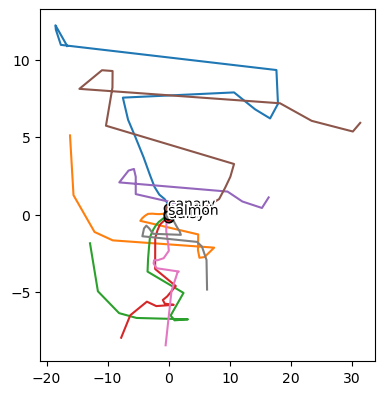

interactive(children=(IntSlider(value=0, description='Layer:', layout=Layout(width='39%'), max=19), Output()),…

In [ ]:
## Get all activations
activations = []

for layer in range(len(model) - 1):
    act = get_activations(val_dataset, lambda inputs: model(inputs)[1][layer], encoding)
    activations.append(act)

index_names = activations[0].index.names
activations = pd.concat(activations, keys=list(range(len(activations))))
activations.index = activations.index.set_names(["Epoch"] + index_names)

animation = SliderAnimation(
    [ActivationsAnimation(activations, transform="PCA_per_epoch", plot_labels=True)],
    parameters=list(set(activations.index.get_level_values("Epoch"))),
    parameter_name="Layer",
    fig_size=4,
)

In [ ]:
from sklearn.decomposition import PCA

data_red = activations.copy().iloc[:, 0:2]
for epoch in activations.groupby("Epoch"):
    pca = PCA(n_components=2)
    data_red.loc[epoch[0]] = pca.fit_transform(epoch[1])

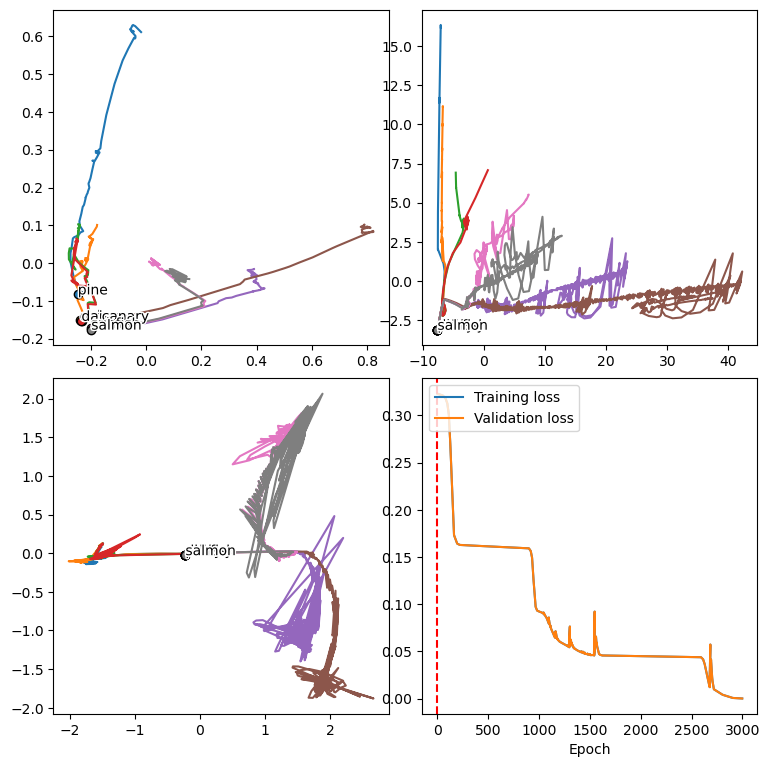

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='39%'), max=2999), Output()…

In [ ]:
## Visualize representation dynamics
data_hid_early = compiler.trackers["hidden_early"].get_trace()
data_hid_late = compiler.trackers["hidden_late"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
data_hid_early = data_hid_early.query(query).copy()
data_hid_late = data_hid_late.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

# weight_change = compiler.trackers["weight change"].get_trace().to_numpy().reshape(-1)

animation = SliderAnimation(
    [
        ActivationsAnimation(
            data_hid_early.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        ActivationsAnimation(
            data_hid_late.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        ActivationsAnimation(
            data_output.query("Dataset != 0"),
            transform="PCA",
            plot_labels=True,
        ),
        EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                # "weight change": weight_change,
            },
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    ],
    parameters=list(set(data_output.index.get_level_values("Epoch"))),
    parameter_name="Epoch",
    fig_size=4,
)

In [ ]:
## Plot reduction
# x = data_hid_early.query("Epoch == 0 and Dataset == 0").to_numpy()
x = inputs
y = data_output.query("Epoch == 0 and Dataset == 0").to_numpy()
D2 = 0
for i, j in zip(x, y):
    D2 += ((np.linalg.norm(j) / np.linalg.norm(i)) ** 2) / x.shape[0]
print(f"D0^2: {D2}")

output_dist2 = 2

m = np.linspace(0, 1, L)

base = np.exp((np.log(D2)) * m)

D0^2: 1.6065038968839467e-20


In [ ]:
def dist2(act1: pd.DataFrame, act2: pd.DataFrame):
    distances = []
    for (epoch, data1_epoch), (epoch, data2_epoch) in zip(
        act1.groupby("Epoch"), act2.groupby("Epoch")
    ):
        distance = 0
        if act1 is act2:
            n = len(data1_epoch) * len(data2_epoch) - 1
        else:
            n = len(data1_epoch) * len(data2_epoch)
        for input_1, act_1 in data1_epoch.groupby("Input"):
            for input_2, act_2 in data2_epoch.groupby("Input"):
                distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
        distances.append(distance)
    distances2 = np.array([dist**2 for dist in distances])

    return distances2

In [ ]:
## Compute input/output distances
plant = ["pine", "oak", "rose", "daisy"]
animal = ["robin", "canary", "sunfish", "salmon"]
tree = ["pine", "oak"]

input_act = properties.T
input_act.index = input_act.index.set_names("Input")
input_act = input_act.assign(Epoch=[0] * len(properties.T)).set_index(
    "Epoch", append=True
)
input_act = input_act.assign(Dataset=[0] * len(properties.T)).set_index(
    "Dataset", append=True
)

input_dist2_plant = dist2(input_act.loc[plant], input_act.loc[plant])
input_dist2_animal = dist2(input_act.loc[animal], input_act.loc[animal])
input_dist2_plant_animal = dist2(input_act.loc[plant], input_act.loc[animal])
input_dist2_tree = dist2(input_act.loc[tree], input_act.loc[tree])

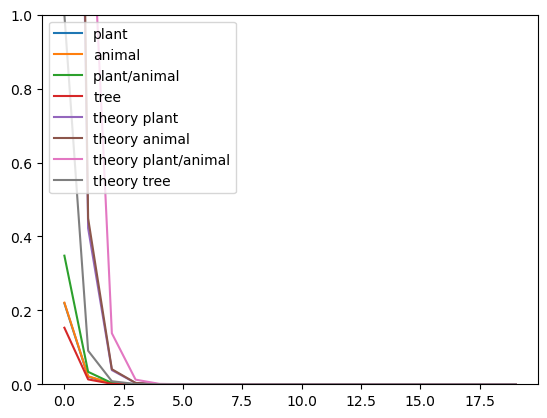

In [ ]:
## Plot distances before training
act_0_plant = activations_0.loc[:, :, plant]
act_0_animal = activations_0.loc[:, :, animal]
act_0_tree = activations_0.loc[:, :, tree]

dist2_0_plant = dist2(act_0_plant, act_0_plant)
dist2_0_animal = dist2(act_0_animal, act_0_animal)
dist2_0_plant_animal = dist2(act_0_plant, act_0_animal)
dist2_0_tree = dist2(act_0_tree, act_0_tree)

plt.plot(dist2_0_plant, label="plant")
plt.plot(dist2_0_animal, label="animal")
plt.plot(dist2_0_plant_animal, label="plant/animal")
plt.plot(dist2_0_tree, label="tree")
plt.plot(input_dist2_plant * base, label="theory plant")
plt.plot(input_dist2_animal * base, label="theory animal")
plt.plot(input_dist2_plant_animal * base, label="theory plant/animal")
plt.plot(input_dist2_tree * base, label="theory tree")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()

/tmp/ipykernel_2718/4171508096.py:20: RuntimeWarning: divide by zero encountered in divide
  h = 1 + 2 * np.sqrt(input_dist2_plant_animal / output_dist2) * m / (1 - m) * D2 ** (
/tmp/ipykernel_2718/4171508096.py:25: RuntimeWarning: divide by zero encountered in divide
  h = 1 + 2 * np.sqrt(input_dist2_plant / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)
/tmp/ipykernel_2718/4171508096.py:27: RuntimeWarning: divide by zero encountered in divide
  h = 1 + 2 * np.sqrt(input_dist2_tree / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)


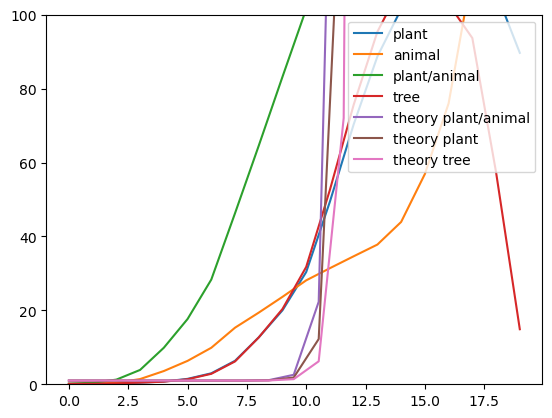

In [ ]:
## Plot distances
act_plant = data_red.loc[:, :, plant]
act_animal = data_red.loc[:, :, animal]
act_tree = data_red.loc[:, :, tree]

dist2_plant = dist2(act_plant, act_plant)
dist2_animal = dist2(act_animal, act_animal)
dist2_plant_animal = dist2(act_plant, act_animal)
dist2_tree = dist2(act_tree, act_tree)
# dist2_full = dist2(activations_0, activations_0)
dist2_full = 1

plt.plot(dist2_plant / dist2_full, label="plant")
plt.plot(dist2_animal / dist2_full, label="animal")
plt.plot(dist2_plant_animal / dist2_full, label="plant/animal")
plt.plot(dist2_tree / dist2_full, label="tree")

## input is output

h = 1 + 2 * np.sqrt(input_dist2_plant_animal / output_dist2) * m / (1 - m) * D2 ** (
    0.5 - m
)

plt.plot(m * L, h, label="theory plant/animal")
h = 1 + 2 * np.sqrt(input_dist2_plant / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)
plt.plot(m * L, h, label="theory plant")
h = 1 + 2 * np.sqrt(input_dist2_tree / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)
plt.plot(m * L, h, label="theory tree")

plt.ylim(0, 100)
plt.legend(loc="upper right")
plt.show()

/tmp/ipykernel_2718/421477649.py:4: RuntimeWarning: divide by zero encountered in divide
  h = 1 + 2 * np.sqrt(input_dist2_plant_animal / output_dist2) * m / (1 - m) * D2 ** (
/tmp/ipykernel_2718/421477649.py:8: RuntimeWarning: divide by zero encountered in divide
  h = 1 + 2 * np.sqrt(input_dist2_plant / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)
/tmp/ipykernel_2718/421477649.py:10: RuntimeWarning: divide by zero encountered in divide
  h = 1 + 2 * np.sqrt(input_dist2_tree / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)


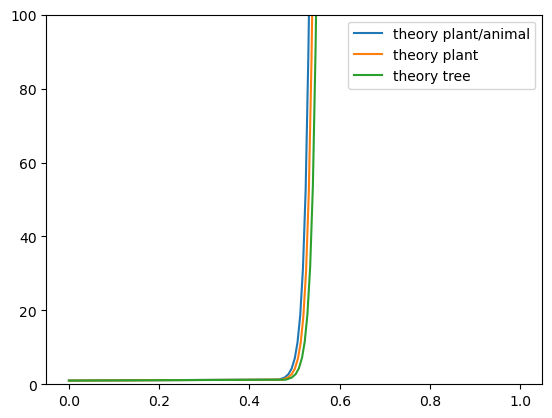

In [ ]:
m = np.linspace(0, 1, 1000)
D2 = 0.0000000000000000000000000000000000001

h = 1 + 2 * np.sqrt(input_dist2_plant_animal / output_dist2) * m / (1 - m) * D2 ** (
    0.5 - m
)
plt.plot(m, h, label="theory plant/animal")
h = 1 + 2 * np.sqrt(input_dist2_plant / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)
plt.plot(m, h, label="theory plant")
h = 1 + 2 * np.sqrt(input_dist2_tree / output_dist2) * m / (1 - m) * D2 ** (0.5 - m)
plt.plot(m, h, label="theory tree")

plt.ylim(0, 100)
plt.legend(loc="upper right")
plt.show()

In [ ]:
name = "Partial Out-of-dataset generalization"
# animation.to_gif("plots/" + name, step_size=int(len(train_loss) / 1000))